In [1]:
!conda install -y pytorch torchvision cudatoolkit=10.2 -c pytorch
!pip install pytorch-lightning
!pip install tqdm
!pip install albumentations
!pip install segyio
!pip install patchify
!pip install -y albumentations

Solving environment: done

# All requested packages already installed.




Usage:   
  pip install [options] <requirement specifier> [package-index-options] ...
  pip install [options] -r <requirements file> [package-index-options] ...
  pip install [options] [-e] <vcs project url> ...
  pip install [options] [-e] <local project path> ...
  pip install [options] <archive url/path> ...

no such option: -y


In [2]:
import numpy as np
import os
import random
import torch
import pytorch_lightning as pl

In [3]:
seed = 7
random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
np.random.seed(seed)
pl.seed_everything(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


In [4]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import segyio

from model import ABPN_v5
from torchvision import transforms
from collections import OrderedDict
import math
import torch.nn.functional as F
from patchify import patchify, unpatchify
from torch import nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
import cv2
import albumentations as A
from PIL import Image
from glob import glob
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from skimage.metrics import structural_similarity as ssim

In [5]:
output_path = 'result/{epoch}-{val_loss:.5f}'
image_size = 128

In [6]:
seismic = segyio.tools.cube('rosneft_data.sgy')

In [7]:
# MinMax scaling
seismic_min = seismic.min()
seismic_max = seismic.max()
seismic = (seismic - seismic_min) / (seismic_max - seismic_min)

In [8]:
seismic.shape

(512, 384, 384)

Данные Роснефти содержат только 10% исходного куба.

### Визуализация среза

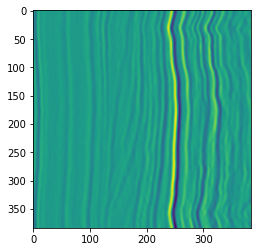

In [9]:
plt.imshow(seismic[0, :, :])

### Подготовка данных

Сохранение инлайнов и кросслайнов

In [10]:
# разбиение на train и test не случайно, чтобы снизить взаимосвязь между ними
os.makedirs('test', exist_ok=True)
os.makedirs('train', exist_ok=True)

# Разбиение на две выборки: 80% обучающая выборка, 20% валидационная
split = int(round(seismic.shape[0] * 0.8))
train_seismic = seismic[:split, :, :]
test_seismic = seismic[split:, :, :]
print(train_seismic.shape, test_seismic.shape) 

(410, 384, 384) (102, 384, 384)


In [11]:
# срезы обучающей выборки (по одной оси на данный момент) сохраняются на диск
# патчи 128х128 будут случайно выбираться в ходе обучения
for x in tqdm(range(train_seismic.shape[0])):
    np.save(f'train/{x}', train_seismic[x])
    
# валидационные изображения разбиваются на непересекающиеся патчи 128x128 и сохраняются на диск
for x in tqdm(range(test_seismic.shape[0])):
    patches = patchify(test_seismic[x], (image_size, image_size), step=image_size)
    for i, patch_seq in enumerate(patches):
        for j, patch in enumerate(patch_seq):
            np.save(f'test/patch_{x}_{i}_{j}.npy', patch)

In [12]:
x_train, x_test = [], []
for file_path in tqdm(glob('train/*.npy')):
    x_train.append(np.load(file_path))

for file_path in tqdm(glob('test/*.npy')):
    x_test.append(np.load(file_path))
    
print(len(x_train), len(x_test))


410 918


In [13]:
def down_sample(img):
    new_image = cv2.resize(img ,(img.shape[0]//4, img.shape[0]//4), cv2.INTER_CUBIC)
    return new_image

In [14]:
random_crop = A.Compose([
    A.RandomCrop(image_size, image_size, p=1.),
    A.RandomRotate90(p=0.5),
    A.Flip(p=0.5),
#     A.ElasticTransform(p=0.4),
#     A.GridDistortion(p=0.4)
])
y_transform = transforms.Compose([
    transforms.ToTensor(),
#     transforms.Normalize((0.5), (0.5))
])
x_transform = transforms.Compose([
    transforms.Lambda(down_sample),
    transforms.ToTensor(),
#     transforms.Normalize((0.5), (0.5))
])

In [15]:
class Seismic2D(Dataset):
    def __init__(self, images, train=True):
        self.images = images
        self.train = train
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        y = self.images[idx]
        if self.train:
            y = random_crop(image=y)['image']
        x = x_transform(y)
        y = y_transform(y)
        return x, y

In [16]:
train_dataset = Seismic2D(x_train) 
test_dataset = Seismic2D(x_test, train=False)

### Metrics

In [17]:
def eval_psnr(x, y):
    mse = np.mean( (x - y) ** 2 )
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

In [18]:
def eval_ssim(x, y):
    ssim_metric = ssim(x, y,
                  data_range=y.max() - y.min(), multichannel=True)
    return ssim_metric
    

### Model

In [19]:
for x, y in DataLoader(test_dataset, batch_size=16, num_workers=4, shuffle=False):
    grid = utils.make_grid(x)
    utils.save_image(grid, 'input_val.png')
    break

In [20]:
class SuperRes(pl.LightningModule):
    def __init__(self, in_channel, image_size, learning_rate, batch_size=None):
        super(SuperRes, self).__init__()
        self.L1_criterion = nn.L1Loss()
        self.model = ABPN_v5(input_dim=in_channel, dim=image_size)
#         self.model.load_state_dict(torch.load('pretrained/ABPN_4x.pth'))
        self.batch_size = batch_size
        self.learning_rate = learning_rate


    def forward(self, z):
        return self.model(z)

    def training_step(self, batch, batch_nb):
        x, y = batch
        if self.on_gpu:
            x = x.cuda(x.device.index)
            y = y.cuda(x.device.index)
        preds = self(x)
        loss = self.L1_criterion(preds, y)
        tensorboard_logs = {'train_loss': loss}
        return {'loss': loss, 'log': tensorboard_logs}

        
    def validation_step(self, batch, batch_nb):
        # batch
        x, y = batch
        if self.on_gpu:
            x = x.cuda(x.device.index)
            y = y.cuda(x.device.index)
            
        preds = self(x)
        if batch_nb == 0:
            self.val_preds = preds.clone().detach()
        val_loss = self.L1_criterion(preds, y)

        return {'val_loss': val_loss}
    
        
    def validation_epoch_end(self, outputs):
        avg_loss = torch.mean(torch.tensor([x['val_loss'] for x in outputs]))
        tensorboard_logs = {'val_loss': torch.tensor(avg_loss)}
        return {'val_loss': torch.tensor(avg_loss), 'progress_bar': tensorboard_logs,
                'log': tensorboard_logs}
    
            
    def val_dataloader(self):
        return DataLoader(test_dataset, batch_size=self.batch_size, num_workers=4, shuffle=False)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam([p for p in self.model.parameters() if p.requires_grad],
                                     lr=self.learning_rate)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                     factor=0.1,
                                                     patience=10,
                                                     min_lr=1e-8,
                                                     verbose=True)
        return [optimizer], [scheduler]

    def train_dataloader(self):
        return DataLoader(train_dataset, batch_size=self.batch_size, num_workers=4, shuffle=True)

    def on_epoch_end(self):
        grid = utils.make_grid(self.val_preds)
        self.logger.experiment.add_image(f'generated_images', grid, self.current_epoch)

In [21]:
early_stop_callback = EarlyStopping(monitor='val_loss', min_delta=0.0, patience=20, verbose=False, mode='min', strict=True)
checkpoint_callback = ModelCheckpoint(filepath=output_path, 
                                      monitor='val_loss', mode='min')
model = SuperRes(in_channel=1, image_size=image_size//4, learning_rate=1e-4, batch_size=16)

In [22]:
# trainer = pl.Trainer(gpus=1, gradient_clip_val=0.5,  auto_scale_batch_size=None, auto_lr_find=True,
#                      early_stop_callback=early_stop_callback, checkpoint_callback=checkpoint_callback)
# trainer.fit(model)

### Evaluation

In [23]:
saved_path = 'result/epoch=265-val_loss=0.00685.ckpt'

model = SuperRes(in_channel=1, image_size=image_size//4, learning_rate=1e-4, batch_size=16)
checkpoint = torch.load(saved_path, map_location=torch.device('cuda'))
model.load_state_dict(checkpoint['state_dict'])
model.cuda()
model.eval()

SuperRes(
  (L1_criterion): L1Loss()
  (model): ABPN_v5(
    (feat1): ConvBlock(
      (conv): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act): PReLU(num_parameters=1)
    )
    (SA0): Space_attention(
      (K): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (Q): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (V): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (pool): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
      (local_weight): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    )
    (feat2): ConvBlock(
      (conv): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act): PReLU(num_parameters=1)
    )
    (up1): UpBlock(
      (conv1): DeconvBlock(
        (deconv): ConvTranspose2d(32, 32, kernel_size=(6, 6), stride=(4, 4), padding=(1, 1))
        (act): PReLU(num_parameters=1)
      )
      (conv2): ConvBlock(
        (conv): Conv2d(32, 32, kernel_size=(6, 6), stride=

In [24]:
pnsr_results = []
ssim_results = []
with torch.no_grad():
    for x, y in tqdm(DataLoader(test_dataset, batch_size=16, num_workers=4, shuffle=False)):
        x, y = x.cuda(), y.cuda()
        preds = model(x)
        np_preds, np_y = preds.detach().data.cpu().numpy(), y.detach().data.cpu().numpy()
        np_preds, np_y = np.round(np.clip(255*np_preds, 0, 255)), np.round(np.clip(255*np_y, 0, 255))
        np_preds, np_y = np.moveaxis(np_preds, 1, -1), np.moveaxis(np_y, 1, -1)
        for predicted_image, true_image in zip(np_preds, np_y):
            ssim_metric = eval_ssim(predicted_image, true_image)
            pnsr_metric = eval_psnr(predicted_image, true_image)
            ssim_results.append(ssim_metric)
            pnsr_results.append(pnsr_metric)
print(f'SSIM results on validation data: {np.mean(ssim_results)}')
print(f'PNSR results on validation data: {np.mean(pnsr_results)}')


/home/novel/miniconda3/envs/superres/lib/python3.6/site-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/home/novel/miniconda3/envs/superres/lib/python3.6/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "



SSIM results on validation data: 0.9453492520278878
PNSR results on validation data: 39.837847814117055
